### 数据集准备

MNIST 是一个大规模手写字符数据集，它包含有 55000 个训练样本和 10000 个测试样本。

首先，我们通过 TensorFlow 加载 MNIST 数据集，当然你也可以到 [MNIST 网站](http://yann.lecun.com/exdb/mnist/) 下载。这里已经下载好了

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 读取数据集，TensorFlow 会直接下载数据并且做预处理
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f59a89f43c8>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f59a8981b38>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f59a8981b00>)

代码中的 `one_hot=True` 表示会对目标值进行独热编码，即像前面 DIGITS 的挑战中，会将 `0-9` 的标签处理为独热编码对应的 `样本数*10` 的矩阵。

对数据进行可视化，由于每个字符的原数据已经被处理为`(784,1)`的行向量，所以在绘图前需要将其 reshape 成 `(28,28)` 的矩阵：

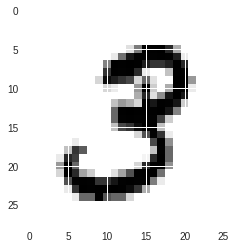

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(mnist.train.images[1].reshape(28,28), cmap=plt.cm.gray_r)

在构建卷积神经网络之前，同样需要先对数据进行处理，这样我们后面才可以执行与上文类似的卷积操作。

这里，用 `trX, trY, tex, tey` 分别保存 MNIST 数据集的训练集图片，训练集标签，测试集图片和测试集标签。

In [3]:
trX,trY,tex,tey = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

# 将平铺的特征重构成 28×28 的图片像素维度
trX = trX.reshape(-1, 28, 28, 1)
tex = tex.reshape(-1, 28, 28, 1)

trX.shape, tex.shape

((55000, 28, 28, 1), (10000, 28, 28, 1))

因为使用的是黑白图片，所以颜色通道为 `1`。同时，为了取出所有数据，所以索引为 `-1`。

### 网络搭建

下面开始构建卷积神经网络。许多实践表明，几个卷积层后跟随一个池化层，再叠上几次相似的结构，同时卷积层的卷积核个数逐渐增大，最后几层通过全连接层连接的网络结构有很强的性能。所以仿制这个思路，一步一步地搭建卷积神经网络。

这一步我们创立了两个占位符，未来对它们进行 `feed` 操作就能对不同数据集进行训练或者预测。

In [0]:
# 图片是28*28大小，但是数量未知，所以数量的维度为 None
x = tf.placeholder(tf.float32, [None, 28, 28, 1])  
y = tf.placeholder(tf.int64, [None, 10])        

考虑到卷积神经网络也需要像神经网络一样首先初始化权值（卷积核），我们利用 `random_normal` 的方式定义一个优化函数，给定任意的矩阵大小，都能按照高斯分布随机优化矩阵数值。其中，`stddev` 是值高斯分布的标准差。

注意，因为权值就是我们要训练学习的参数，所以在未来它肯定是会变的。于是，将其转化为变量形式以利于后面的训练。

In [0]:
# 定义一个初始化权重函数
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

我们想设计一个卷积神经网络包含两个卷积层，第一个卷积层用 `8` 个 $3\times3\times1$ 的卷积核，第二个卷积层用 `10` 个 $3\times3\times8$ 的卷积核。

那么根据这样大小的 `shape`，我们通过调用之前定义的 `init_weights` 函数就可以初始化我们的卷积核了。

In [6]:
w1 = init_weights([3, 3, 1, 8])  # 初始化第一层卷积网络，[3,3,1,8] 是 shape，分别指卷积核高度，宽度，深度和数量
w2 = init_weights([3, 3, 8, 10])  # 初始化第二层卷积网络

Instructions for updating:
Colocations handled automatically by placer.


接下来，使用 TensorFlow 提供的 `tf.nn.conv2d()` 来搭建两层卷积神经网络。这里我们选用 `relu` 作为激活函数。

In [0]:
# 第一层卷积网络，步长均为 1，Same Padding
conv1 = tf.nn.relu(tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='SAME'))

# 第二层卷积网络，高度和宽度步长为 2，数量和深度步长为 1，Same Padding
conv2 = tf.nn.relu(tf.nn.conv2d(conv1, w2, strides=[1, 2, 2, 1], padding='SAME'))

可以看到，第一层卷积网络的输出将作为第二层卷积网络的输入。

紧接着两个卷积层，准备接上一个最大池化层，这里使用 TensorFlow 提供的 `max_pool()`。同样要给出池化层的输入，`ksize` 指池化层的过滤器大小，`strides` 是过滤器在输入上的平移步长，`4` 个维度同样对应样本数，高度，宽度，深度，我们也需要指定 `padding` 方式完善池化层的作用。

In [0]:
# 池化层，池化过滤器大小为对深度 1，高度宽度 4，数量 1，步长相同，valid padding 指不需要 padding
pool = tf.nn.max_pool(conv2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='VALID')

之后，想将池化层的输出用于全连接层。但是由于此时输出是个 `4` 维的矩阵，所以需要将其 reshape 成二维矩阵才可用于全连接层。

In [0]:
# 将池化层平铺用于全连接层，计算得到池化层平铺后大小为 None*90
pool_shaped = tf.reshape(pool, [-1, 10*3*3])

注意，我们 `reshape` 的时候第一个 `shape` 我们取 `-1`，是想通过计算卷积 + 池化后一个图片样本的输出矩阵大小，然后让 `-1` 直接指代样本数做为第一维度。

对于一个图片样本，原本大小为 `784`，`reshape` 后为 $28\times28\times1$，第一个卷积层后大小为 $28\times28\times8$，第二个卷积层后大小降为 $14\times14\times10$，池化层大小再降为 $3\times3\times10$。这样，我们将每一个样本都平铺为一个长 `90` 的向量，那么 `-1` 就可以直接得到样本数的大小构成一个完美的全连接层输入矩阵。

所以，紧接着就给出一个全连接层。输入为上面的 `pool_shaped`，输出尺寸指定为 `None*30`，同样采用 relu 作为激活函数：

In [10]:
# 全连接层，输出矩阵 None*30, relu 激活
fc1 = tf.layers.dense(pool_shaped, 30, activation=tf.nn.relu)

Instructions for updating:
Use keras.layers.dense instead.


由于最终是对 10 个不同的字符进行分类，为了能计算损失，这里还需要再加一个全连接层，把上面的 `None*30` 输出处理成 `None*10`。最后一层了，这里不再需要激活函数。

In [0]:
# 输出预测概率，即与 y 大小相同的预测向量，不需要激活
logits = tf.layers.dense(fc1, 10, activation=None)

### 损失函数及优化器

TensorFlow 号称宇宙第一深度学习框架，所以直接给出了 Softmax 函数 + 交叉熵二合一的类 `tf.nn.softmax_cross_entropy_with_logits_v2()`。其中，`logits` 为输出的各类概率，`y` 为数据本身的真实标签，最后可计算出损失值。

In [0]:
# 交叉熵损失函数，reduce_mean 的目的是对每个样本的计算结果求平均
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))

最后，使用 Adam 优化器求解，这一点就不再赘述了：

In [0]:
optimizer = tf.train.AdamOptimizer()  # Adam 优化器
training_op = optimizer.minimize(loss)  # 求解极小值

为了方便，这里再定义一下准确率的计算方法。`tf.nn.in_top_k()` 顾名思义，把概率最高的作为分类类别，而 `tf.cast()` 用于转换类型。

In [0]:
target = tf.argmax(y, 1) # 目标输出
acc = tf.reduce_mean(tf.cast(tf.nn.in_top_k(logits, target, 1), tf.float32))  # 准确率

### 训练模型

一切准备就绪，这里继续采用 Mini-batch 的方法提高训练效率。建立会话后初始化所有变量，并执行学习过程。同时，还可以绘制出动态的学习曲线变化图，你会看到准确率一点一点上升，成就感爆棚。

<center><font color="red"><strong>注意：下方代码单元格需要在 GPU 环境中才能执行。</strong></font></center>

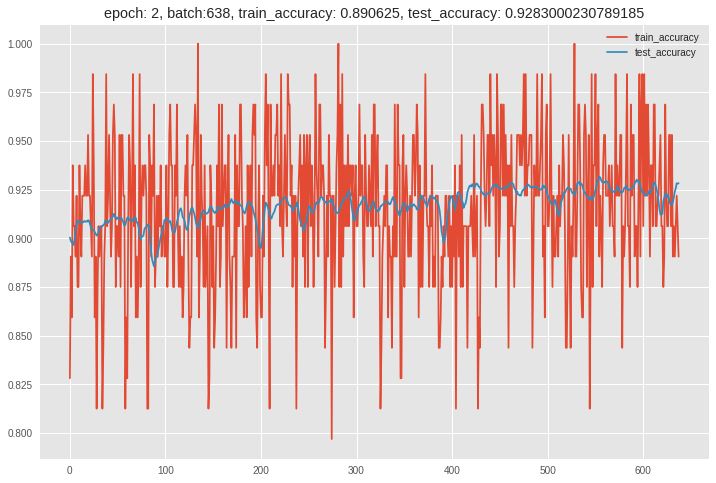

In [0]:
from IPython import display # 引入 display 模块目的方便程序运行展示

batch_size = 64 # 批量大小

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print('训练开始，请耐心等候')
    
    for epoch in range(2):
        train_acc_list = [] # 为了绘图
        test_acc_list = [] # 为了绘图
        train_batch = zip(range(0, len(trX), batch_size), range(batch_size, len(trX) + 1, batch_size)) # 获取批量
        i = 1
        for start, end in train_batch:
            sess.run(training_op, feed_dict={x: trX[start:end], y: trY[start:end]}) # 传入数据
            train_acc = acc.eval(feed_dict={x: trX[start:end], y: trY[start:end]}) # 训练集准确率
            test_acc = acc.eval(feed_dict={x: tex, y: tey}) # 测试集准确率
            
            # 以下是绘图代码
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            
            display.clear_output(wait=True)
            plt.style.use('ggplot')
            plt.figure(figsize=(12, 8))
            plt.plot(train_acc_list, label='train_accuracy')
            plt.plot(test_acc_list, label='test_accuracy')
            plt.legend()
            plt.title("epoch: {}, batch:{}, train_accuracy: {}, test_accuracy: {}".format(epoch+1, i, train_acc, test_acc))
            plt.show()
            i+=1